<a href="https://colab.research.google.com/github/heizsen/Ai/blob/main/Azis_Feature_Engineering_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A. Outliers Explanation

## Purpose

We will:

- Identify outliers in Normally distributed variables.
- Identify outliers in skewed variables.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
# Load the Boston House dataset from sklearn
boston_dataset = pd.read_csv('https://raw.githubusercontent.com/ardhiraka/FSDS_Guidelines/master/p1/v3/w1/P1W1D2PM%20-%20Feature%20Engineering%20-%20Part%202%20-%20Boston.csv')

# Create a dataframe with the independent variables
# Legends :
  # - CRIM     per capita crime rate by town
  # - RM       average number of rooms per dwelling
  # - LSTAT    % lower status of the population

boston = boston_dataset[['RM', 'LSTAT', 'CRIM']]
boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


In [ ]:
# Load the Titanic dataset

url = 'https://www.openml.org/data/get_csv/16826755/phpMYEkMl'
titanic = pd.read_csv(url, usecols=['age', 'fare'])

# The variables age and fare have missing values. For this missing value, let's remove them.
titanic.dropna(subset=['age', 'fare'], inplace=True)
titanic['age'] = pd.to_numeric(titanic['age'], errors = 'coerce')
titanic['fare'] = pd.to_numeric(titanic['fare'], errors = 'coerce')
titanic['age'] = titanic['age'].astype(float)
titanic['fare'] = titanic['fare'].astype(float)

print('Shape data : ', titanic.shape, '\n')
print(titanic.info(), '\n')
titanic.head()

Shape data :  (1309, 2) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     1046 non-null   float64
 1   fare    1308 non-null   float64
dtypes: float64(2)
memory usage: 20.6 KB
None 



,age,fare
0,29.0000,211.3375
1,0.9167,151.5500
2,2.0000,151.5500
3,30.0000,151.5500
4,25.0000,151.5500


## Identify variable distribution

In Normally distributed variables, outliers are those values that lie beyond the mean plus or minus 3 times the standard deviation. If the variables are skewed however, we find outliers using the inter-quantile range. In order to decide which method to utilise to detect outliers, we first need to know the distribution of the variable.

We can use histograms to determine if the variable is normally distributed. We can also use boxplots to directly visualise the outliers. Boxplots are a standard way of displaying the distribution of a variable utilising the first quartile, the median, the third quartile and the whiskers.

Looking at a boxplot, you can easily identify:

- The median, indicated by the line within the box.
- The inter-quantile range (IQR), the box itself.
- The quantiles, 25th (Q1) is the lower and 75th (Q3) the upper end of the box.
- The wiskers, which extend to:
  -- top whisker: Q3 + 1.5 x IQR
  -- bottom whisker: Q1 -1.5 x IQR

Any value sitting outside the whiskers is considered an outlier. Let's look at the examples below.

In [ ]:
# Function to create histogram and boxplot.
# This functions takes a dataframe (df) and the variable of interest as arguments.

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

### Normally distributed variables

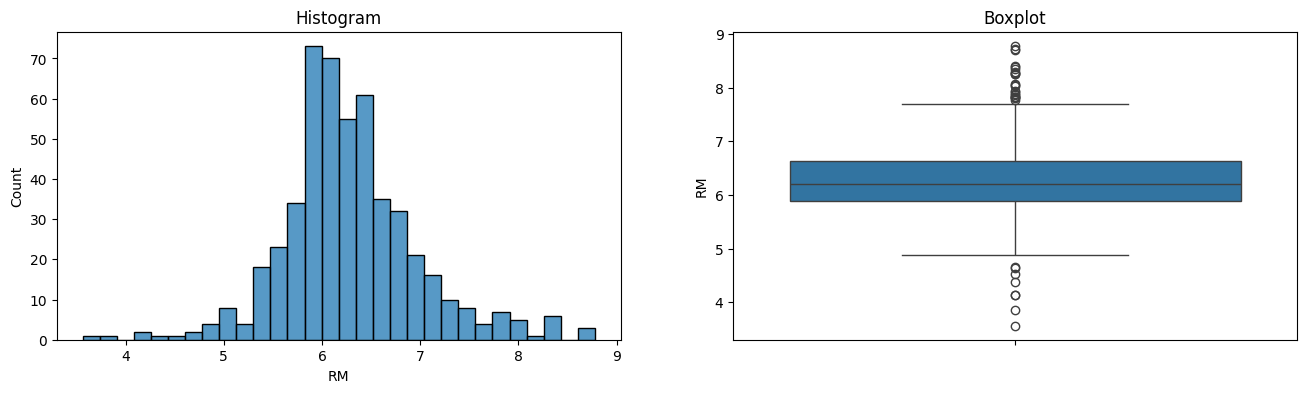


Skewness Value :  0.40361213328874385


In [ ]:
# Let's start with the variable RM from the Boston House dataset.
# RM is the average number of rooms per dwelling

diagnostic_plots(boston, 'RM')
print('\nSkewness Value : ', boston['RM'].skew())

From the histogram, we see that the variable rm approximates a Gaussian distribution quite well. In the boxplot, we see that the variable could have outliers, as there are many dots sitting outside the whiskers, at both tails of the distribution.

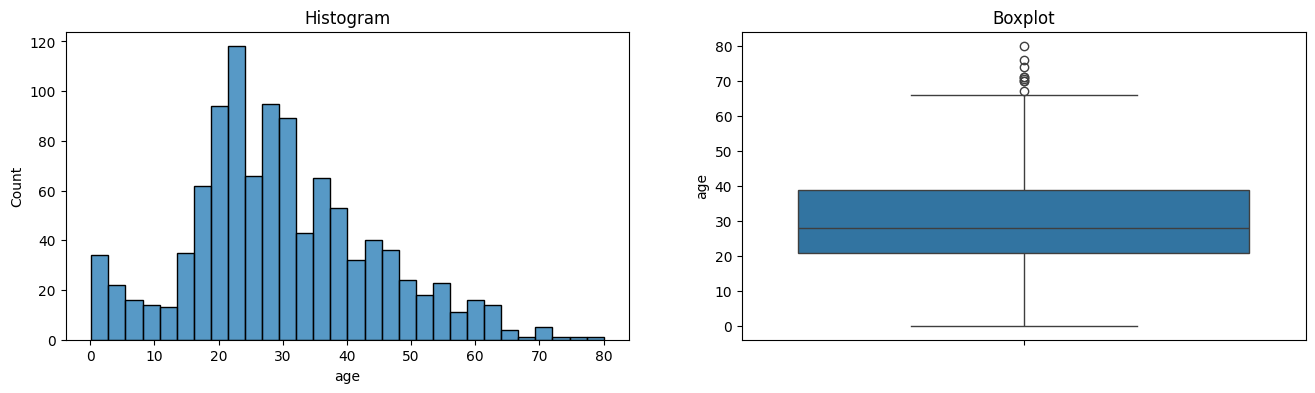


Skewness Value :  0.4076718864978293


In [ ]:
# let's inspect now the variable Age from the titanic
# refers to the age of the passengers on board

diagnostic_plots(titanic, 'age')
print('\nSkewness Value : ', titanic['age'].skew())

From the histogram, we see that the variable approximates fairly well a Gaussian distribution. There is a deviation from the distribution towards the smaller values of age. In the boxplot, we can see that the variable could have outliers, as there are many dots sitting outside the whiskers, at the right end of the distribution (top whisker in the boxplot).

### Skewed variables

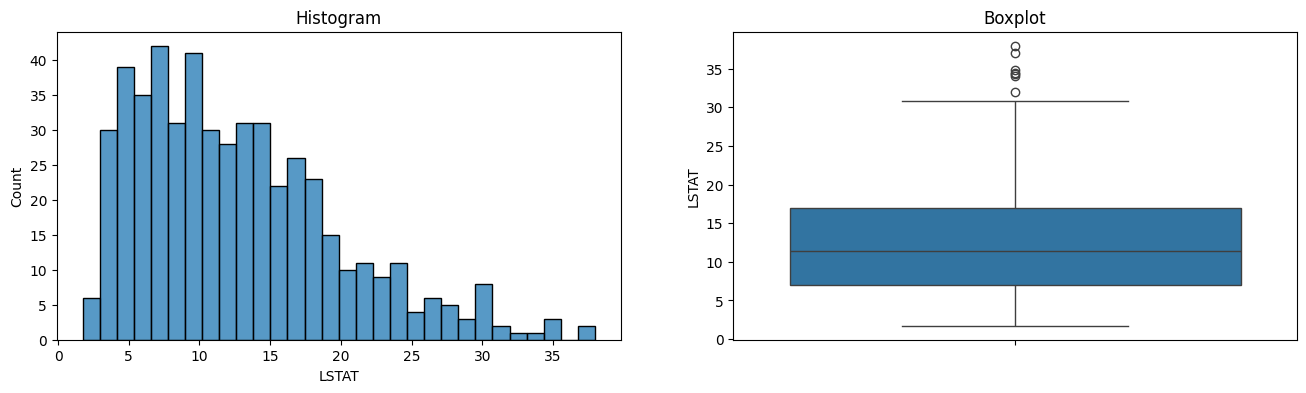


Skewness Value :  0.9064600935915367


In [ ]:
# Variable LSTAT from the boston house dataset
# LSTAT is the % lower status of the population

diagnostic_plots(boston, 'LSTAT')
print('\nSkewness Value : ', boston['LSTAT'].skew())

LSTAT is not normally distributed, it is skewed with a tail to the right. According to the boxplot, there are some outliers at the right end of the distribution of the variable.

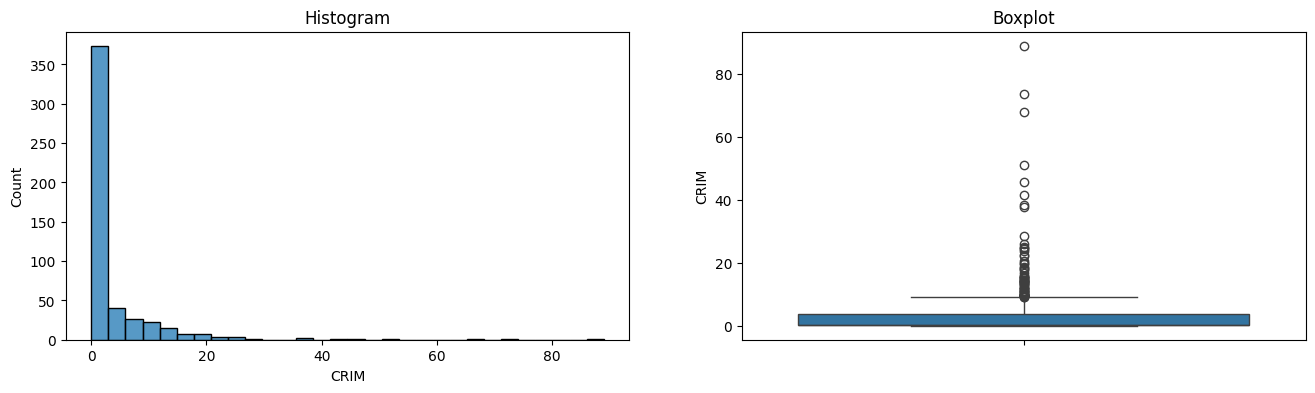


Skewness Value :  5.223148798243851


In [ ]:
# Variable CRIM from the boston house dataset
# CRIM is the per capita crime rate by town

diagnostic_plots(boston, 'CRIM')
print('\nSkewness Value : ', boston['CRIM'].skew())

CRIM is heavily skewed, with a tail to the right. There seems to be quite a few outliers as well at the right end of the distribution, according to the boxplot.

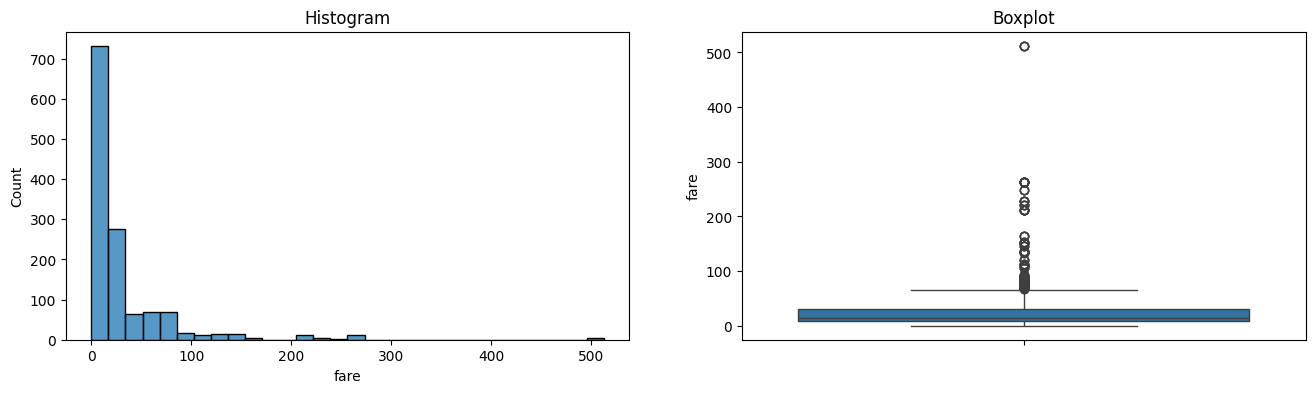


Skewness Value :  4.367709134122922


In [ ]:
# Variable Fare from the titanic dataset
# Fare is the price paid for the ticket by the passengers

diagnostic_plots(titanic, 'fare')
print('\nSkewness Value : ', titanic['fare'].skew())

Fare is also very skewed, and shows some unusual values at the right end of its distribution.

In the next cells, we will identify outliers using :
- the mean and the standard deviation for the variables `RM` and `Age` from the boston and titanic datasets, respectively.
- the inter-quantile range to identify outliers for the variables `LSTAT`, `CRIM` and `Fare` from the boston and titanic datasets.

### Outlier detection for Normally distributed variables

In [ ]:
# Function to find upper and lower boundaries for normally distributed variables
# Calculate the boundaries outside which sit the outliers for a Gaussian distribution

def find_normal_boundaries(df, variable):
    upper_boundary = df[variable].mean() + 3 * df[variable].std()
    lower_boundary = df[variable].mean() - 3 * df[variable].std()

    return upper_boundary, lower_boundary

In [ ]:
# calculate boundaries for RM
upper_boundary, lower_boundary = find_normal_boundaries(boston, 'RM')
upper_boundary, lower_boundary

(8.392485817597748, 4.176782957105809)

From the above we conclude that values **bigger than 8.4** or **smaller than 4.2** occur very rarely for the variable `RM`. Therefore, we can consider them outliers.

In [ ]:
# Inspect the number and percentage of outliers for `RM`

print('Total number of houses: {}'.format(len(boston)))
print('Houses with more than 8.4 rooms (right end outliers) : {}'.format(len(boston[boston['RM'] > upper_boundary])))
print('Houses with less than 4.2 rooms (left end outliers.  : {}'.format(len(boston[boston['RM'] < lower_boundary])))
print('')
print('% right end outliers : {}'.format(len(boston[boston['RM'] > upper_boundary]) / len(boston) * 100))
print('% left end outliers  : {}'.format(len(boston[boston['RM'] < lower_boundary]) / len(boston) * 100))

Total number of houses: 506
Houses with more than 8.4 rooms (right end outliers) : 4
Houses with less than 4.2 rooms (left end outliers.  : 4

% right end outliers : 0.7905138339920948
% left end outliers  : 0.7905138339920948


Using Extreme Value Analysis we identified outliers at both ends of the distribution of `RM`. The percentage of outliers is small (1.58% considering the 2 tails together), which makes sense, because we are finding precisely outliers. That is, rare values, rare occurrences.

Let's move on to `Age` in the titanic dataset.

In [ ]:
# Calculate boundaries for `Age` in the titanic

upper_boundary, lower_boundary = find_normal_boundaries(titanic, 'age')
upper_boundary, lower_boundary

(73.1216336121991, -13.359364587342501)

The upper boundary is **73 years**, which means that passengers older than 73 were very few, if any, in the titanic. The lower boundary is negative. Because negative age does not exist, it only makes sense to look for outliers utilising the upper boundary.

In [ ]:
# Lets look at the number and percentage of outliers

print('Total passengers         : {}'.format(len(titanic)))
print('Passengers older than 73 : {}'.format(len(titanic[titanic['age'] > upper_boundary])))
print('')
print('% of passengers older than 73 : {}'.format(len(titanic[titanic['age'] > upper_boundary]) / len(titanic) * 100))

Total passengers         : 1309
Passengers older than 73 : 3

% of passengers older than 73 : 0.2291825821237586


There were 3 passengers older than 73 on board of the titanic, which could be considered outliers, as the majority of the population where much younger.

### Outlier detection for skewed variables

In [ ]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
# Looking for outliers, using the interquantile proximity rule IQR * 1.5, for `LSTAT` in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'LSTAT', 1.5)
upper_boundary, lower_boundary

(31.962500000000006, -8.057500000000005)

In [ ]:
# Lets look at the number and percentage of outliers for `LSTAT`

print('Total houses : {}'.format(len(boston)))
print('Houses with LSTAT bigger than 32   : {}'.format(len(boston[boston['LSTAT'] > upper_boundary])))
print('')
print('% houses with LSTAT bigger than 32 : {}'.format(len(boston[boston['LSTAT'] > upper_boundary])/len(boston) * 100))

Total houses : 506
Houses with LSTAT bigger than 32   : 7

% houses with LSTAT bigger than 32 : 1.383399209486166


The upper boundary shows a value of ~32. The lower boundary is negative, however the variable `LSTAT` does not take negative values. So to calculate the outliers for LSTAT we only use the upper boundary. This coincides with what we observed in the boxplot earlier in the notebook. Outliers sit only at the right tail of LSTAT's distribution. **We observe 7 houses, 1.38 % of the dataset, with extremely high values for `LSTAT`.**

In [ ]:
# Looking for outliers, using the interquantile proximity rule IQR * 1.5, for `CRIM` in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'CRIM', 1.5)
upper_boundary, lower_boundary

(9.06963875, -5.31051125)

In [ ]:
# Lets look at the number and percentage of outliers for `CRIM`

print('Total houses : {}'.format(len(boston)))
print('Houses with CRIM bigger than 9   : {}'.format(len(boston[boston['CRIM'] > upper_boundary])))
print('')
print('% houses with CRIM bigger than 9 : {}'.format(len(boston[boston['CRIM'] > upper_boundary]) / len(boston) * 100))

Total houses : 506
Houses with CRIM bigger than 9   : 66

% houses with CRIM bigger than 9 : 13.043478260869565


In [ ]:
# Looking for outliers, using the interquantile proximity rule IQR * 3, now lets looking for extremely high values for `CRIM` in the boston house dataset

upper_boundary, lower_boundary = find_skewed_boundaries(boston, 'CRIM', 3)
upper_boundary, lower_boundary

(14.462195000000001, -10.7030675)

In [ ]:
# Lets look at the number and percentage of outliers for `CRIM`

print('Total houses : {}'.format(len(boston)))
print('Houses with CRIM bigger than 14   : {}'.format(len(boston[boston['CRIM'] > upper_boundary])))
print('')
print('% houses with CRIM bigger than 14 : {}'.format(len(boston[boston['CRIM'] > upper_boundary]) / len(boston) * 100))

Total houses : 506
Houses with CRIM bigger than 14   : 30

% houses with CRIM bigger than 14 : 5.928853754940711


When using :
- the 1.5 times inter-quantile range to find outliers, we find that **~13%** of the houses show unusually high crime rate areas.
- the 3 times inter-quantile range to find outliers, we find that **~6%** of the houses show unusually high crime rate areas.

For `CRIM` as well, the lower boundary is negative, so it only makes sense to use the upper boundary to calculate outliers, as the variable takes only positive values. This coincides with what we observed in `CRIM`'s boxplot earlier in this notebook.

In [ ]:
# Finally, identify outliers in `Fare` in the titanic dataset. Lets look again for extreme values using IQR * 3

upper_boundary, lower_boundary = find_skewed_boundaries(titanic, 'fare', 3)
upper_boundary, lower_boundary

(101.4126, -62.24179999999999)

In [ ]:
# Lets look at the number and percentage of passengers who paid extremely high Fares

print('Total passengers : {}'.format(len(titanic)))
print('Passengers who paid more than 117   : {}'.format(len(titanic[titanic['fare'] > upper_boundary])))
print('')
print('% passengers who paid more than 117 : {}'.format(len(titanic[titanic['fare'] > upper_boundary])/len(titanic) * 100))

Total passengers : 1309
Passengers who paid more than 117   : 84

% passengers who paid more than 117 : 6.417112299465241


For Fare, as well as for all the other variables in this notebook which show a tail to the right, the lower boundary is negative. So we will use the upper boundary to determine the outliers. We observe that 6.4% of the values of the dataset fall above the boundary.

# B. Trimming

## Trimming or truncation

Trimming, also known as truncation, involves removing the outliers from the dataset. We only need to decide on a metric to determine outliers. As we saw in section 3, this can be the Gaussian approximation for normally distributed variables or the inter-quantile range proximity rule for skewed variables.

### Advantages

- quick

### Limitations

- outliers for one variable could contain useful information in the other variables
- if there are outliers across many variables, we could remove a big chunk of dataset

## Important

Outliers should be detected AND **removed ONLY** from the training set, and NOT from the test set. So we should first divide our data set into train and tests, and remove outliers in the train set, but keep those in the test set, and measure how well our model is doing.

## Purpose

We will see how to perform **trimming** using the Boston House Dataset.

In [ ]:
# Create a dataframe with the independent variables
# Legends :
  # - DIS      weighted distances to five Boston employment centres
  # - LSTAT    % lower status of the population
  # - CRIM     per capita crime rate by town

boston = boston_dataset[['DIS', 'LSTAT', 'CRIM']]
boston.head()

,DIS,LSTAT,CRIM
0,4.0900,4.98,0.00632
1,4.9671,9.14,0.02731
2,4.9671,4.03,0.02729
3,6.0622,2.94,0.03237
4,6.0622,5.33,0.06905


In [ ]:
# Function to create histogram and boxplot.
# Function takes a dataframe (df) and the variable of interest as arguments

def diagnostic_plots(df, variable):
    # Define figure size
    plt.figure(figsize=(16, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    plt.show()

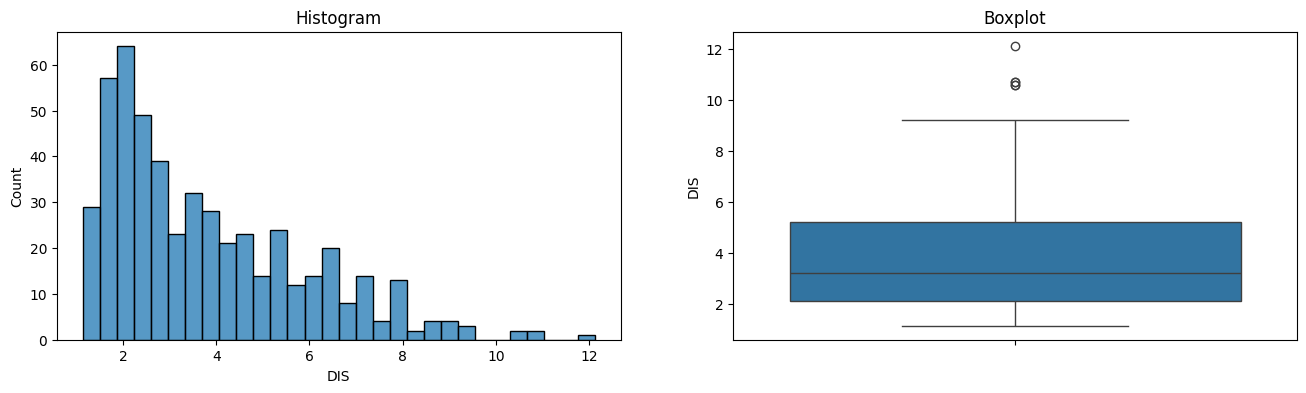

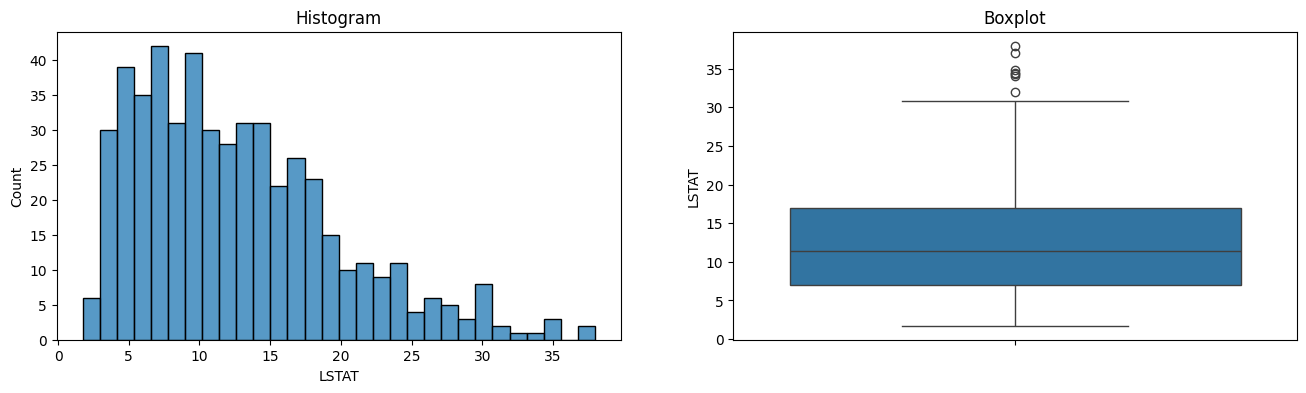

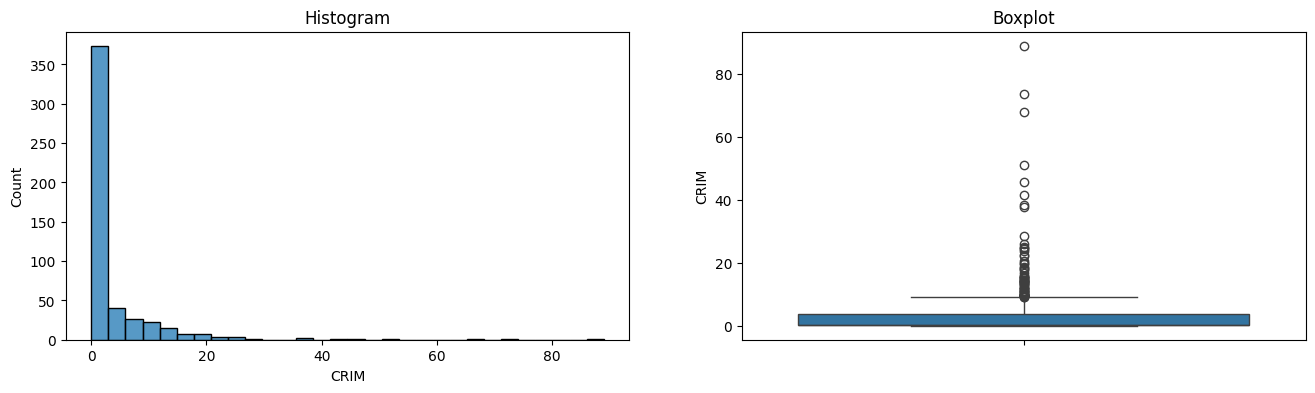

In [ ]:
# Let's find outliers in `DIS`, `LSTAT`, `CRIM`

diagnostic_plots(boston, 'DIS')
diagnostic_plots(boston, 'LSTAT')
diagnostic_plots(boston, 'CRIM')

There are outliers in all of the above variables.

In [ ]:
# Function to find upper and lower boundaries for skewed distributed variables
# Let's calculate the boundaries outside which sit the outliers for skewed distributions
# Distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.

def find_skewed_boundaries(df, variable, distance):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary

In [ ]:
# Limits for `DIS`
DIS_upper_limit, DIS_lower_limit = find_skewed_boundaries(boston, 'DIS', 1.5)
DIS_upper_limit, DIS_lower_limit

# Limits for `LSTAT`
LSTAT_upper_limit, LSTAT_lower_limit = find_skewed_boundaries(boston, 'LSTAT', 1.5)
LSTAT_upper_limit, LSTAT_lower_limit

# Limits for `CRIM`
CRIM_upper_limit, CRIM_lower_limit = find_skewed_boundaries(boston, 'CRIM', 1.5)
CRIM_upper_limit, CRIM_lower_limit

print('DIS_upper_limit : ', DIS_upper_limit)
print('DIS_lower_limit : ', DIS_lower_limit, '\n')
print('LSTAT_upper_limit : ', LSTAT_upper_limit)
print('LSTAT_lower_limit : ', LSTAT_lower_limit, '\n')
print('CRIM_upper_limit : ', CRIM_upper_limit)
print('CRIM_lower_limit : ', CRIM_lower_limit)

DIS_upper_limit :  9.820800000000002
DIS_lower_limit :  -2.5322000000000005 

LSTAT_upper_limit :  31.962500000000006
LSTAT_lower_limit :  -8.057500000000005 

CRIM_upper_limit :  9.06963875
CRIM_lower_limit :  -5.31051125


In [ ]:
# Flag the outliers in category `DIS`
outliers_DIS = np.where(boston['DIS'] > DIS_upper_limit, True,
                       np.where(boston['DIS'] < DIS_lower_limit, True, False))

# Flag the outliers in category `LSTAT`
outliers_LSTAT = np.where(boston['LSTAT'] > LSTAT_upper_limit, True,
                       np.where(boston['LSTAT'] < LSTAT_lower_limit, True, False))

# Flag the outliers in category `CRIM`
outliers_CRIM = np.where(boston['CRIM'] > CRIM_upper_limit, True,
                       np.where(boston['CRIM'] < CRIM_lower_limit, True, False))

print(outliers_DIS[:10])

[False False False False False False False False False False]


In [ ]:
# Let's trimm the dataset

boston_trimmed = boston.loc[~(outliers_DIS + outliers_LSTAT + outliers_CRIM)]
print('Size dataset - Before trimming : ', boston.shape)
print('Size dataset - After trimming  : ', boston_trimmed.shape)

Size dataset - Before trimming :  (506, 3)
Size dataset - After trimming  :  (434, 3)


We can see that using trimming, **we removed 72 rows**, from a dataset of 506 rows, this is about **~14.2%** of the data was removed. This is mostly why, we do not tend to use trimming much in machine learning. But if only a few variables present a tiny proportion of outliers, trimming could work.

DIS - Before Trimming


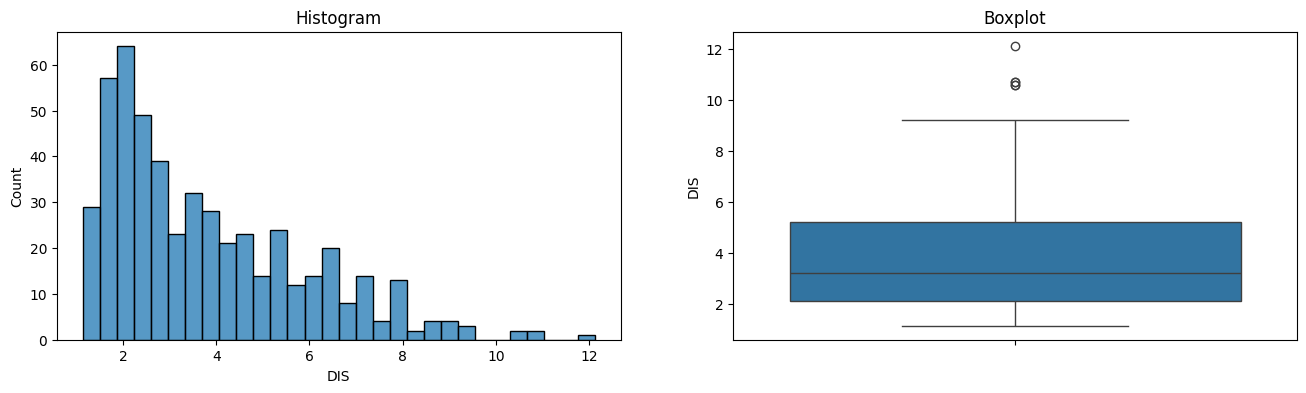


DIS - After Trimming


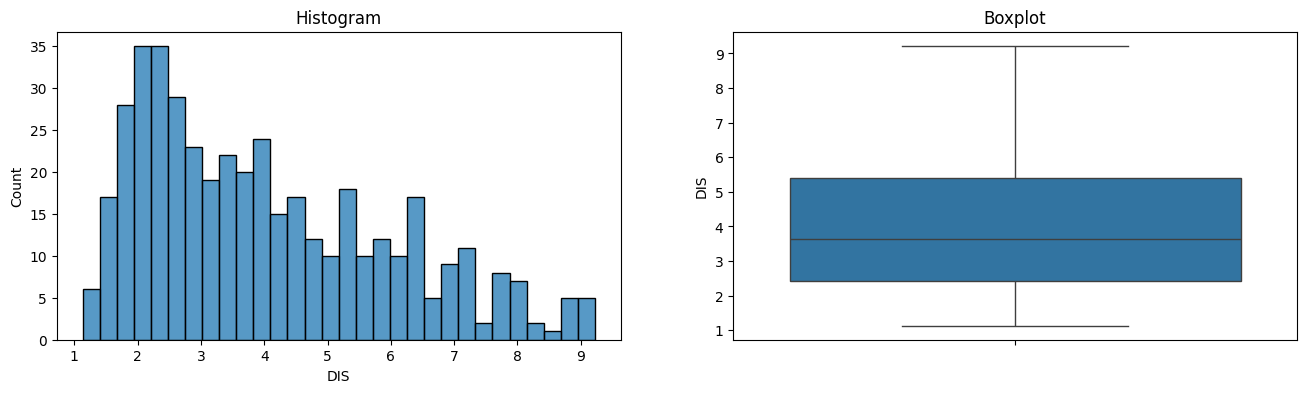


LSTAT - Before Trimming


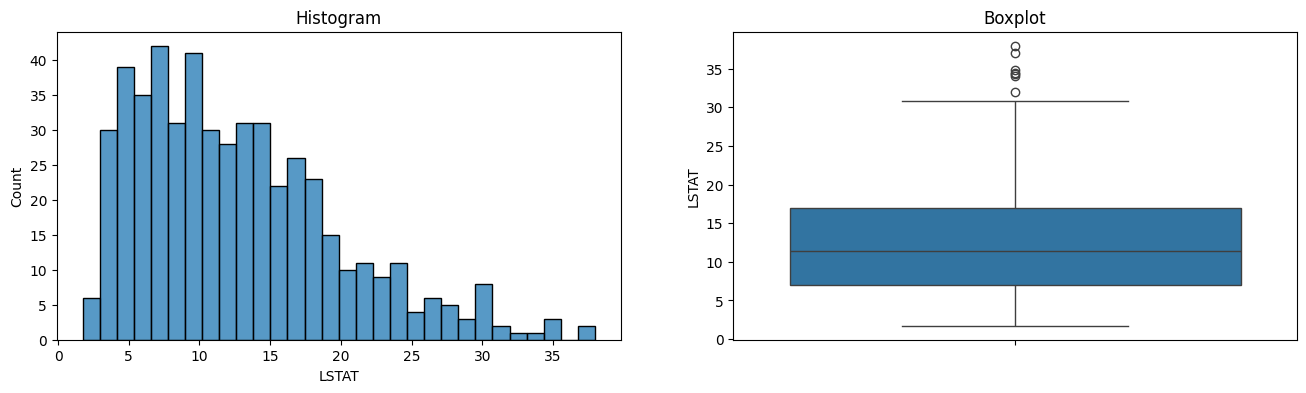


LSTAT - After Trimming


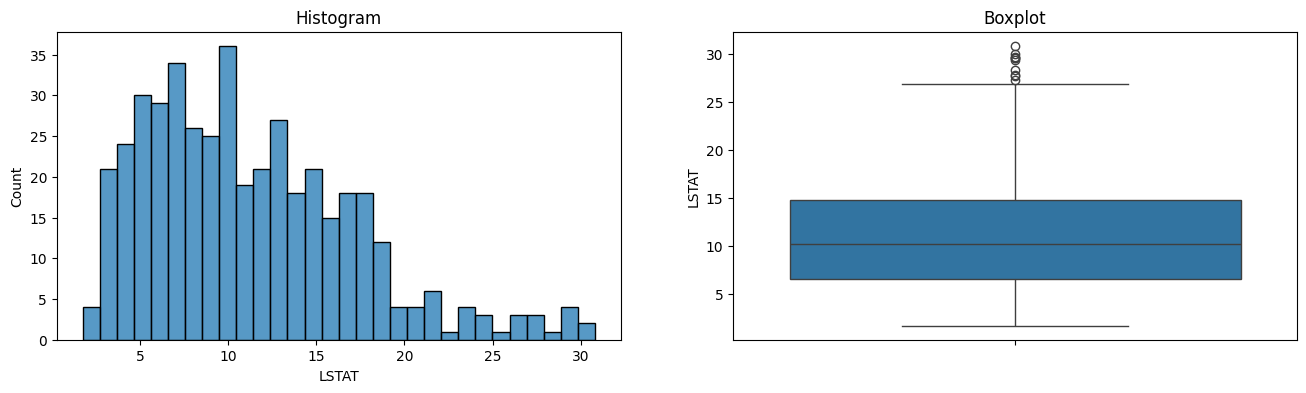


CRIM - Before Trimming


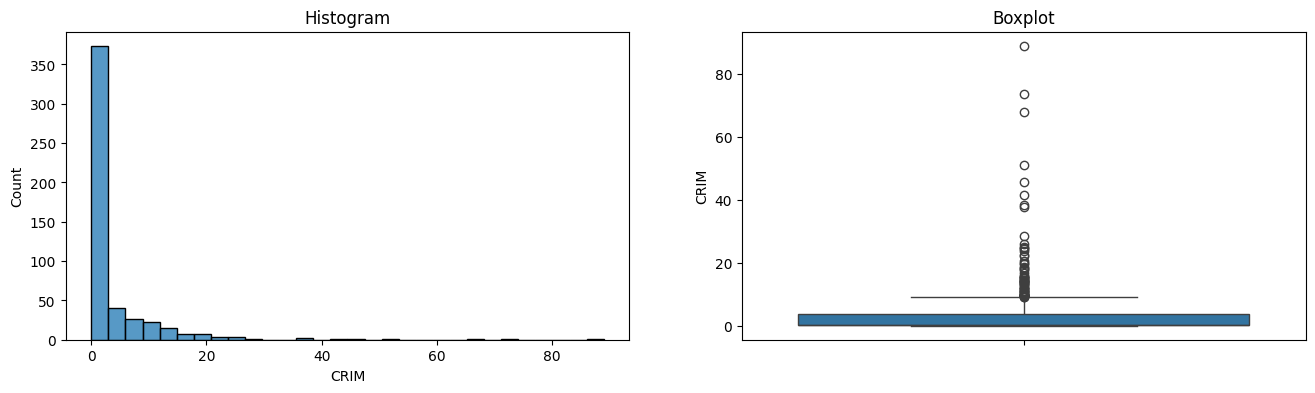


CRIM - After Trimming


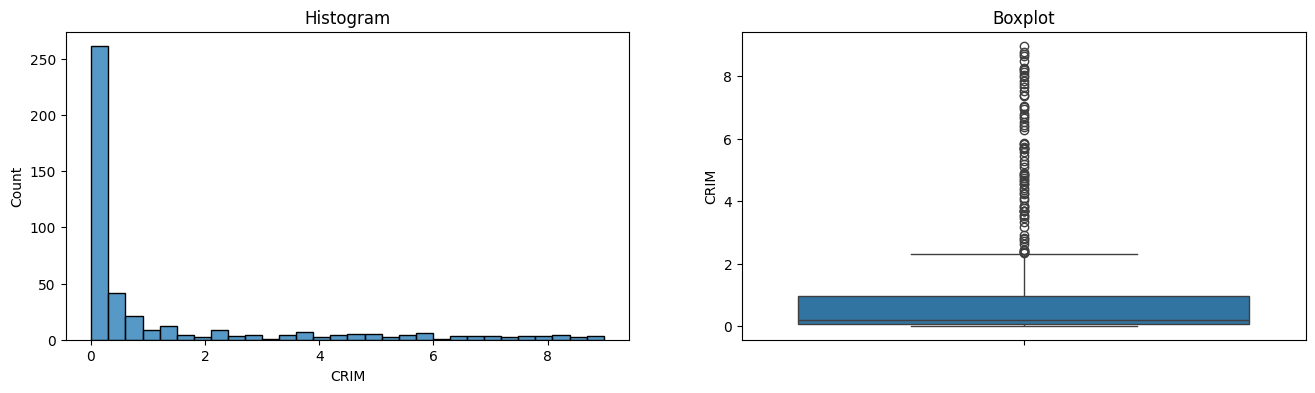

In [ ]:
# Let's find outliers in `DIS`, `LSTAT`, `CRIM`

print('DIS - Before Trimming')
diagnostic_plots(boston, 'DIS')
print('\nDIS - After Trimming')
diagnostic_plots(boston_trimmed, 'DIS')

print('\nLSTAT - Before Trimming')
diagnostic_plots(boston, 'LSTAT')
print('\nLSTAT - After Trimming')
diagnostic_plots(boston_trimmed, 'LSTAT')

print('\nCRIM - Before Trimming')
diagnostic_plots(boston, 'CRIM')
print('\nCRIM - After Trimming')
diagnostic_plots(boston_trimmed, 'CRIM')

For `LSTAT` and `CRIM`, we still see many outliers. **When we remove data points from our dataset, all the parameters of the distribution are re-calculated**, those are the mean, quantiles and inter-quantile range, therefore, in the new -trimmed- variable, values that before were not considered outliers, now are. This is an unwanted characteristic of this way of coping with outliers.

# C. Censoring

## Censoring or Capping.

**Censoring**, or **capping**, means capping the maximum and /or minimum of a distribution at an arbitrary value. On other words, values bigger or smaller than the arbitrarily determined ones are **censored**.

Capping can be done at both tails, or just one of the tails, depending on the variable and the user.

### Advantages

- does not remove data

### Limitations

- distorts the distributions of the variables
- distorts the relationships among variables

## Important

When doing capping, we tend to cap values both in train and test set. It is important to remember that the capping values MUST be derived from the train set. And then use those same values to cap the variables in the test set

## Purpose

We will see how to perform **capping** with the inter-quantile range bold textproximity rule using the Boston House Dataset

In [ ]:
!pip install feature-engine

from feature_engine.outliers import Winsorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 3.4 MB/s eta 0:00:00


In [ ]:
# Create a dataframe with the independent variables
# Legends :
  # - DIS      weighted distances to five Boston employment centres
  # - LSTAT    % lower status of the population
  # - CRIM     per capita crime rate by town

boston = boston_dataset[['DIS', 'LSTAT', 'CRIM']]
boston.head()

,DIS,LSTAT,CRIM
0,4.0900,4.98,0.00632
1,4.9671,9.14,0.02731
2,4.9671,4.03,0.02729
3,6.0622,2.94,0.03237
4,6.0622,5.33,0.06905


In [ ]:
# Create the capper

windsoriser = Winsorizer(capping_method='iqr', # choose iqr for IQR rule boundaries or gaussian for mean and std
                          tail='both', # cap left, right or both tails
                          fold=1.5,
                          variables=['DIS', 'LSTAT', 'CRIM'])

windsoriser.fit(boston)

boston_t = windsoriser.transform(boston)

In [ ]:
# Inspect the minimum caps for each variable
print('Left Tail Caps  : ', windsoriser.left_tail_caps_)

# Iinspect the maximum caps for each variable
print('Right Tail Caps : ', windsoriser.right_tail_caps_)

Left Tail Caps  :  {'DIS': -2.5322000000000005, 'LSTAT': -8.057500000000005, 'CRIM': -5.31051125}
Right Tail Caps :  {'DIS': 9.820800000000002, 'LSTAT': 31.962500000000006, 'CRIM': 9.06963875}


In [ ]:
print('Boston Dataframe - Before Capping')
print(boston.describe())
print('')
print('Boston Dataframe - After Capping')
print(boston_t.describe())

Boston Dataframe - Before Capping
              DIS       LSTAT        CRIM
count  506.000000  506.000000  506.000000
mean     3.795043   12.653063    3.613524
std      2.105710    7.141062    8.601545
min      1.129600    1.730000    0.006320
25%      2.100175    6.950000    0.082045
50%      3.207450   11.360000    0.256510
75%      5.188425   16.955000    3.677083
max     12.126500   37.970000   88.976200

Boston Dataframe - After Capping
              DIS       LSTAT        CRIM
count  506.000000  506.000000  506.000000
mean     3.783947   12.612011    2.225032
std      2.069765    7.016829    3.313353
min      1.129600    1.730000    0.006320
25%      2.100175    6.950000    0.082045
50%      3.207450   11.360000    0.256510
75%      5.188425   16.955000    3.677083
max      9.820800   31.962500    9.069639


DIS - Before Capping


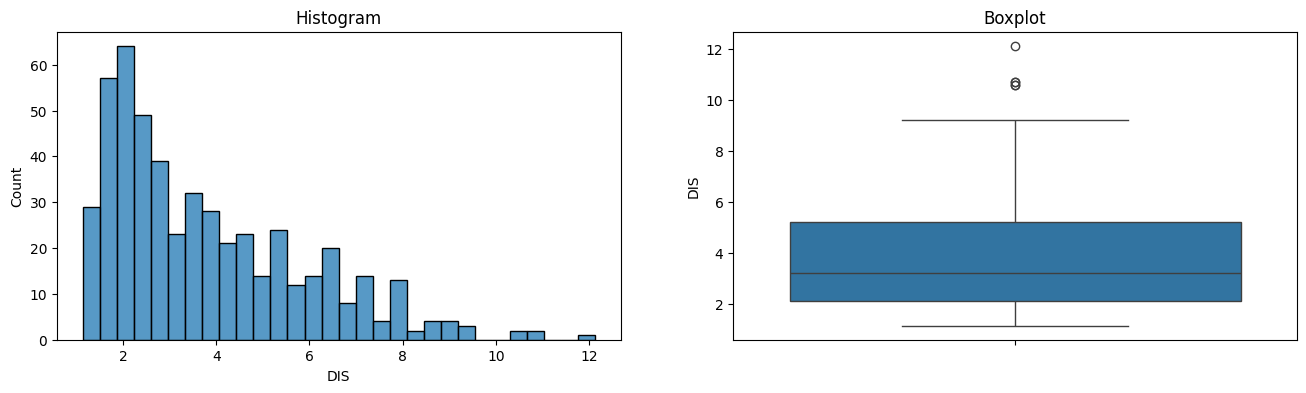


DIS - After Capping


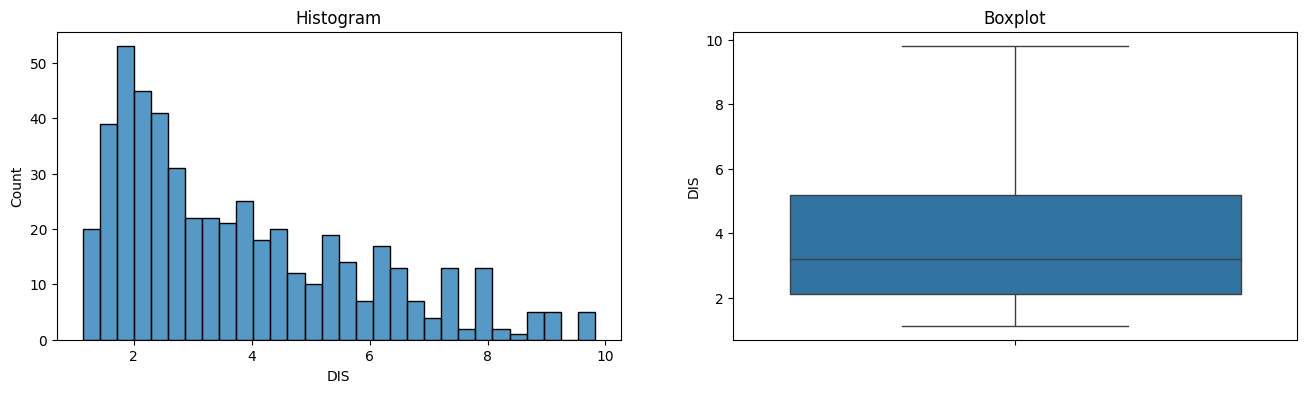


LSTAT - Before Capping


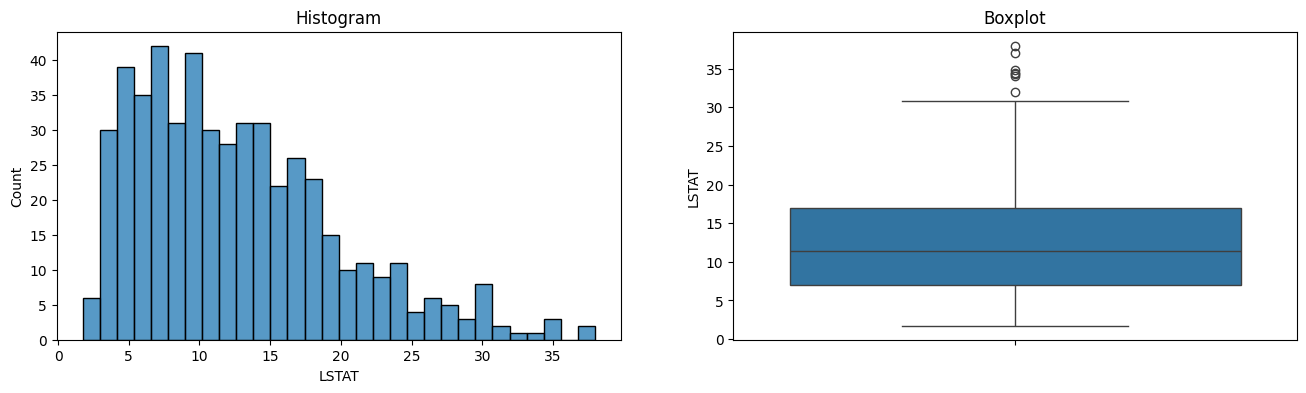


LSTAT - After Capping


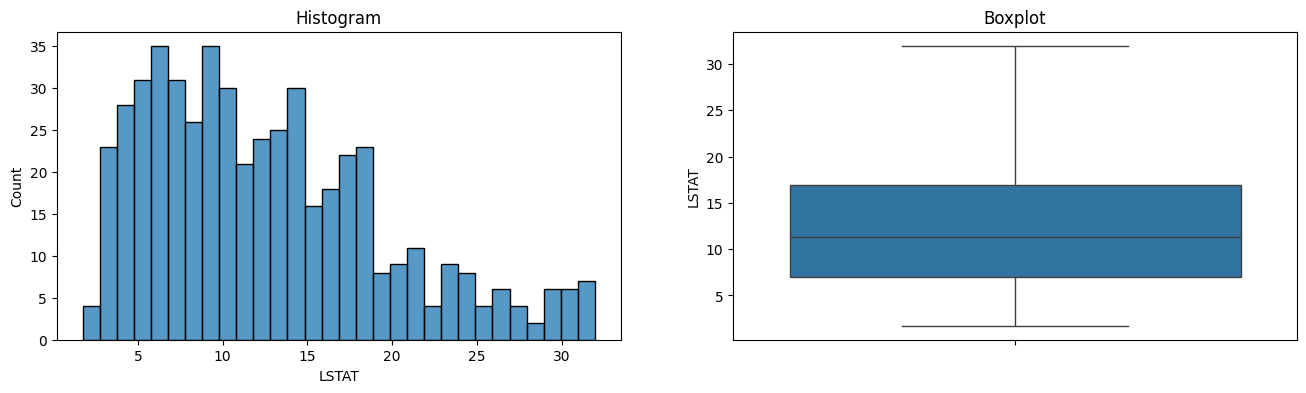


CRIM - Before Capping


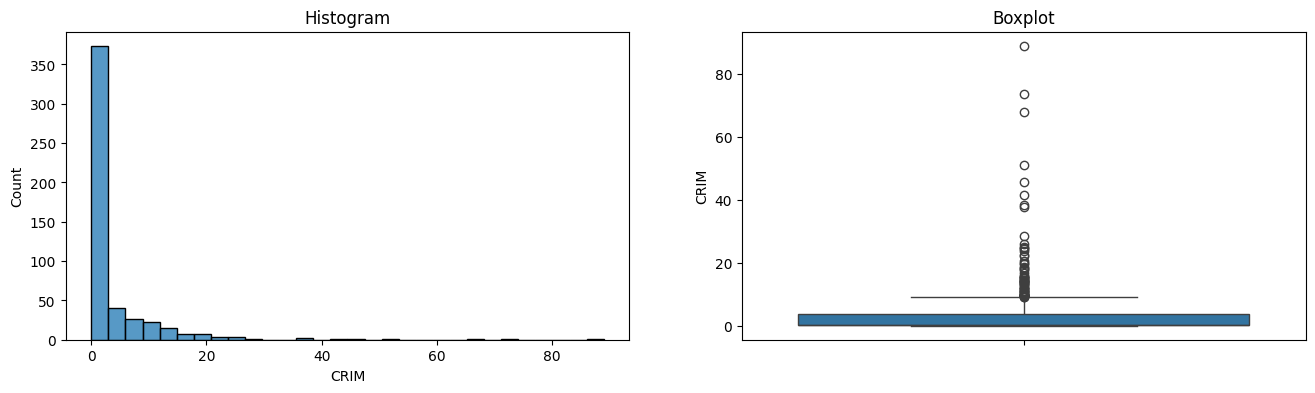


CRIM - After Capping


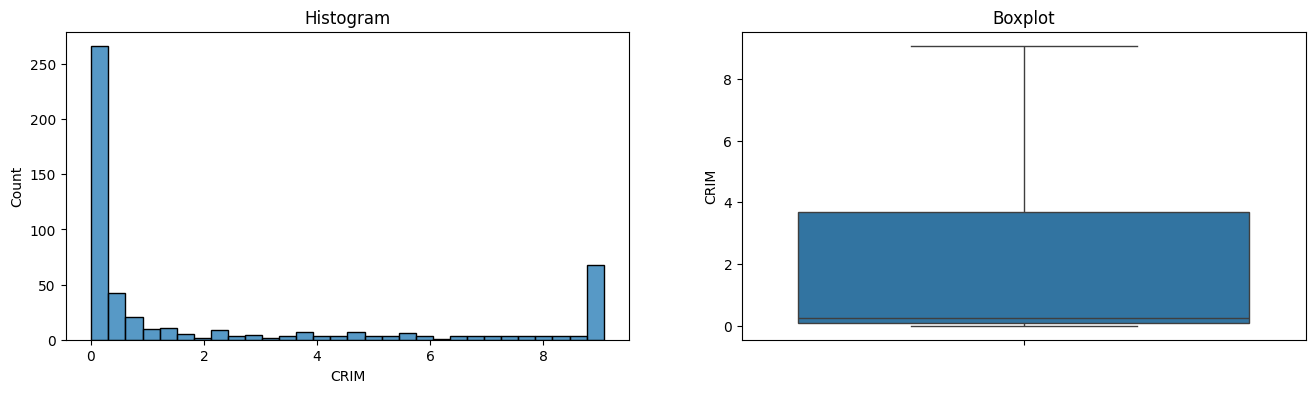

In [ ]:
# Let's find outliers in `DIS`, `LSTAT`, `CRIM`

print('DIS - Before Capping')
diagnostic_plots(boston, 'DIS')
print('\nDIS - After Capping')
diagnostic_plots(boston_t, 'DIS')

print('\nLSTAT - Before Capping')
diagnostic_plots(boston, 'LSTAT')
print('\nLSTAT - After Capping')
diagnostic_plots(boston_t, 'LSTAT')

print('\nCRIM - Before Capping')
diagnostic_plots(boston, 'CRIM')
print('\nCRIM - After Capping')
diagnostic_plots(boston_t, 'CRIM')

# E. Cardinality

The values of a categorical variable are selected from a group of categories, also called labels. For example, in the variable _gender_ the categories or labels are male and female, whereas in the variable _city_ the labels can be London, Manchester, Brighton and so on.

Different categorical variables contain different number of labels or categories. The variable gender contains only 2 labels, but a variable like city or postcode, can contain a huge number of different labels.

The number of different labels within a categorical variable is known as cardinality. A high number of labels within a variable is known as __high cardinality__.


### Are multiple labels in a categorical variable a problem?

High cardinality may pose the following problems:

- Variables with too many labels **tend to dominate** over those with only a few labels, particularly in **Tree based** algorithms.

- A big number of labels within a variable may introduce noise with little, if any, information, therefore making machine learning models **prone to over-fit**.

- Some of the labels may **only be present in the training data set, but not in the test set**, therefore machine learning algorithms may over-fit to the training set.

- Contrarily, **some labels may appear only in the test set**, therefore leaving the machine learning algorithms unable to perform a calculation over the new (unseen) observation.


In particular, **tree methods can be biased towards variables with lots of labels** (variables with high cardinality). Thus, their performance may be affected by high cardinality.

## Purpose :

We will :

- Learn how to quantify cardinality
- See examples of high and low cardinality variables
- Understand the effect of cardinality when preparing train and test sets
- Visualise the effect of cardinality on Machine Learning Model performance

We will use the Titanic dataset. *(URL : https://www.openml.org/data/get_csv/16826755/phpMYEkMl)*

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [ ]:
# Load the Titanic dataset

url = 'https://www.openml.org/data/get_csv/16826755/phpMYEkMl'
data = pd.read_csv(url)
data.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,?,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.55,C22 C26,S,11,?,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.55,C22 C26,S,?,135,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.55,C22 C26,S,?,?,"Montreal, PQ / Chesterville, ON"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   pclass     1309 non-null   int64 
 1   survived   1309 non-null   int64 
 2   name       1309 non-null   object
 3   sex        1309 non-null   object
 4   age        1309 non-null   object
 5   sibsp      1309 non-null   int64 
 6   parch      1309 non-null   int64 
 7   ticket     1309 non-null   object
 8   fare       1309 non-null   object
 9   cabin      1309 non-null   object
 10  embarked   1309 non-null   object
 11  boat       1309 non-null   object
 12  body       1309 non-null   object
 13  home.dest  1309 non-null   object
dtypes: int64(4), object(10)
memory usage: 143.3+ KB


Let's focus on several categorical variables in this dataset : `Name`, `Sex`, `Ticket`, `Cabin`, and `Embarked`.

In [ ]:
# Let's inspect the cardinality, this is the number of different labels, for the different categorical variables

print('Number of categories in the variable Name     : {}'.format(len(data.name.unique())))
print('Number of categories in the variable Gender   : {}'.format(len(data.sex.unique())))
print('Number of categories in the variable Ticket   : {}'.format(len(data.ticket.unique())))
print('Number of categories in the variable Cabin    : {}'.format(len(data.cabin.unique())))
print('Number of categories in the variable Embarked : {}'.format(len(data.embarked.unique())))
print('Total number of passengers in the Titanic.    : {}'.format(len(data)))

Number of categories in the variable Name     : 1307
Number of categories in the variable Gender   : 2
Number of categories in the variable Ticket   : 929
Number of categories in the variable Cabin    : 187
Number of categories in the variable Embarked : 4
Total number of passengers in the Titanic.    : 1309


While the variable `Sex` contains only 2 categories and `Embarked` 4 (low cardinality), the variables `Ticket`, `Name` and `Cabin`, as expected, contain a huge number of different labels (high cardinality).

To demonstrate the effect of high cardinality in train and test sets and machine learning performance, let's work with the variable `Cabin`. We will create a new variable to reduced cardinality.

In [ ]:
# Let's explore the values / categories of `Cabin`
# We know from the previous cell that there are 187 different cabins, therefore the variable is highly cardinal
data.cabin.unique()

array(['B5', 'C22 C26', 'E12', 'D7', 'A36', 'C101', '?', 'C62 C64', 'B35',
       'A23', 'B58 B60', 'D15', 'C6', 'D35', 'C148', 'C97', 'B49', 'C99',
       'C52', 'T', 'A31', 'C7', 'C103', 'D22', 'E33', 'A21', 'B10', 'B4',
       'E40', 'B38', 'E24', 'B51 B53 B55', 'B96 B98', 'C46', 'E31', 'E8',
       'B61', 'B77', 'A9', 'C89', 'A14', 'E58', 'E49', 'E52', 'E45',
       'B22', 'B26', 'C85', 'E17', 'B71', 'B20', 'A34', 'C86', 'A16',
       'A20', 'A18', 'C54', 'C45', 'D20', 'A29', 'C95', 'E25', 'C111',
       'C23 C25 C27', 'E36', 'D34', 'D40', 'B39', 'B41', 'B102', 'C123',
       'E63', 'C130', 'B86', 'C92', 'A5', 'C51', 'B42', 'C91', 'C125',
       'D10 D12', 'B82 B84', 'E50', 'D33', 'C83', 'B94', 'D49', 'D45',
       'B69', 'B11', 'E46', 'C39', 'B18', 'D11', 'C93', 'B28', 'C49',
       'B52 B54 B56', 'E60', 'C132', 'B37', 'D21', 'D19', 'C124', 'D17',
       'B101', 'D28', 'D6', 'D9', 'B80', 'C106', 'B79', 'C47', 'D30',
       'C90', 'E38', 'C78', 'C30', 'C118', 'D36', 'D48', 'D47', '

Let's now reduce the cardinality of the variable. How? Instead of using the entire `cabin` value, we will capture only the
**first letter**.

***Rationale***: the first letter indicates the deck on which the cabin was located, and is therefore an indication of both social class status and proximity to the surface of the Titanic. Both are known to improve the probability of survival.

In [ ]:
# Let's capture the first letter of Cabin

data['Cabin_reduced'] = data['cabin'].astype(str).str[0]

print(data[['cabin', 'Cabin_reduced']].head())
print('Number of categories in the variable Cabin : {}'.format(len(data.cabin.unique())))
print('Number of categories in the variable Cabin reduced : {}'.format(len(data.Cabin_reduced.unique())))

     cabin Cabin_reduced
0       B5             B
1  C22 C26             C
2  C22 C26             C
3  C22 C26             C
4  C22 C26             C
Number of categories in the variable Cabin : 187
Number of categories in the variable Cabin reduced : 9


We reduced the number of different labels from 187 to 9.

In [ ]:
# Let's separate into training and testing set in order to build machine learning models

use_cols = ['cabin', 'Cabin_reduced', 'sex']

X_train, X_test, y_train, y_test = train_test_split(data[use_cols],
                                                    data['survived'],
                                                    test_size=0.3,
                                                    random_state=0)

X_train.shape, X_test.shape

((916, 3), (393, 3))

### High cardinality leads to uneven distribution of categories in train and test sets

When a variable is highly cardinal, often some categories land only on the training set, or only on the testing set. If present only in the training set, they may lead to over-fitting. If present only on the testing set, the machine learning algorithm will not know how to handle them, as it has not seen them during training.

In [ ]:
# Let's find out labels that only present in the training set and labels that only present in the test set

unique_to_train_set = [x for x in X_train.cabin.unique() if x not in X_test.cabin.unique()]
unique_to_test_set = [x for x in X_test.cabin.unique() if x not in X_train.cabin.unique()]

print('Total unique_to_train_set : ', len(unique_to_train_set))
print('Total unique_to_test_set  : ', len(unique_to_test_set))

Total unique_to_train_set :  116
Total unique_to_test_set  :  36


There are **116 Cabins only present in the training set**, and not in the testing set. Also, there are **36 Cabins that only present in the test set** but not in the train set.

Variables with high cardinality tend to have values (i.e., categories) present in the training set, that are not present in the test set, and vice versa. This will bring problems at the time of training (due to over-fitting) and scoring of new data (how should the model deal with unseen categories?). This problem is almost overcome by reducing the cardinality of the variable.

In [ ]:
# Let's find out labels that only present in the training set and only present in the test set for Cabin with reduced cardinality

unique_to_train_set = [
    x for x in X_train['Cabin_reduced'].unique()
    if x not in X_test['Cabin_reduced'].unique()
]

unique_to_test_set = [
    x for x in X_test['Cabin_reduced'].unique()
    if x not in X_train['Cabin_reduced'].unique()
]

print('Total unique_to_train_set : ', len(unique_to_train_set))
print('Total unique_to_test_set  : ', len(unique_to_test_set))

Total unique_to_train_set :  1
Total unique_to_test_set  :  0


Observe how by reducing the cardinality there is now **only 1 label in the training set** that is not present in the test set. And **no label in the test set** that is not contained in the training set as well.

### Effect of cardinality on Machine Learning Model Performance

In order to evaluate the effect of categorical variables in machine learning models, we will quickly replace the categories by numbers. See below.

In [ ]:
# Let's re-map Cabin into numbers so we can use it to train ML models

# I will replace each cabin by a number
# to quickly demonstrate the effect of
# labels on machine learning algorithms

cabin_dict = {k: i for i, k in enumerate(X_train.cabin.unique(), 0)}
print('cabin_dict : ', cabin_dict)
print('Total Cabin Unique - X_train : ', len(X_train.cabin.unique()))
print('Total Cabin Unique - Data    : ', len(data.cabin.unique()))

cabin_dict :  {'?': 0, 'E36': 1, 'C68': 2, 'E24': 3, 'C22 C26': 4, 'D38': 5, 'B50': 6, 'A24': 7, 'C111': 8, 'F': 9, 'C6': 10, 'C87': 11, 'E8': 12, 'B45': 13, 'C93': 14, 'D28': 15, 'D36': 16, 'C125': 17, 'B35': 18, 'T': 19, 'B73': 20, 'B57 B59 B63 B66': 21, 'A26': 22, 'A18': 23, 'B96 B98': 24, 'G6': 25, 'C78': 26, 'C101': 27, 'D9': 28, 'D33': 29, 'C128': 30, 'E50': 31, 'B26': 32, 'B69': 33, 'E121': 34, 'C123': 35, 'B94': 36, 'A34': 37, 'D': 38, 'C39': 39, 'D43': 40, 'E31': 41, 'B5': 42, 'D17': 43, 'F33': 44, 'E44': 45, 'D7': 46, 'A21': 47, 'D34': 48, 'A29': 49, 'D35': 50, 'A11': 51, 'B51 B53 B55': 52, 'D46': 53, 'E60': 54, 'C30': 55, 'D26': 56, 'E68': 57, 'A9': 58, 'B71': 59, 'D37': 60, 'F2': 61, 'C55 C57': 62, 'C89': 63, 'C124': 64, 'C23 C25 C27': 65, 'C126': 66, 'E49': 67, 'F E46': 68, 'E46': 69, 'D19': 70, 'B58 B60': 71, 'C82': 72, 'B52 B54 B56': 73, 'C92': 74, 'E45': 75, 'F G73': 76, 'C65': 77, 'E25': 78, 'B3': 79, 'D40': 80, 'C91': 81, 'B102': 82, 'B61': 83, 'F G63': 84, 'A20': 85,

In [ ]:
# Replace the labels in Cabin, using the dict `cabin_dict` created above
X_train.loc[:, 'Cabin_mapped'] = X_train.loc[:, 'cabin'].map(cabin_dict)
X_test.loc[:, 'Cabin_mapped'] = X_test.loc[:, 'cabin'].map(cabin_dict)

X_train[['Cabin_mapped', 'cabin']].head(10)

,Cabin_mapped,cabin
501,0,?
588,0,?
402,0,?
1193,0,?
686,0,?
971,0,?
117,1,E36
540,0,?
294,2,C68
261,3,E24


In [ ]:
# Display First 10 Data in `X_train`
X_train.head(10)

,cabin,Cabin_reduced,sex,Cabin_mapped
501,?,?,female,0
588,?,?,female,0
402,?,?,female,0
1193,?,?,male,0
686,?,?,female,0
971,?,?,male,0
117,E36,E,female,1
540,?,?,female,0
294,C68,C,male,2
261,E24,E,male,3


We see how NaN takes the value 0 in the new variable, E36 takes the value 1, C68 takes the value 2, and so on.

In [ ]:
# Now we will replace the letters in the reduced cabin variable (`Cabin_reduced`) with the same procedure

# Create replace dictionary
cabin_dict = {k: i for i, k in enumerate(X_train['Cabin_reduced'].unique(), 0)}

print('Before Replace')
print(X_train[['Cabin_reduced', 'cabin']].head(10))
print('')

# Replace labels by numbers with dictionary
X_train.loc[:, 'Cabin_reduced'] = X_train.loc[:, 'Cabin_reduced'].map(cabin_dict)
X_test.loc[:, 'Cabin_reduced'] = X_test.loc[:, 'Cabin_reduced'].map(cabin_dict)

print('After Replace')
print(X_train[['Cabin_reduced', 'cabin']].head(10))
print('')

Before Replace
     Cabin_reduced cabin
501              ?     ?
588              ?     ?
402              ?     ?
1193             ?     ?
686              ?     ?
971              ?     ?
117              E   E36
540              ?     ?
294              C   C68
261              E   E24

After Replace
      Cabin_reduced cabin
501               0     ?
588               0     ?
402               0     ?
1193              0     ?
686               0     ?
971               0     ?
117               1   E36
540               0     ?
294               2   C68
261               1   E24



<ipython-input-50-8a4c81a1afb9>:11: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.loc[:, 'Cabin_reduced'] = X_train.loc[:, 'Cabin_reduced'].map(cabin_dict)
<ipython-input-50-8a4c81a1afb9>:12: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.loc[:, 'Cabin_reduced'] = X_test.loc[:, 'Cabin_reduced'].map(cabin_dict)


In [ ]:
# Display First 10 Data in `X_train`
X_train.head(10)

,cabin,Cabin_reduced,sex,Cabin_mapped
501,?,0,female,0
588,?,0,female,0
402,?,0,female,0
1193,?,0,male,0
686,?,0,female,0
971,?,0,male,0
117,E36,1,female,1
540,?,0,female,0
294,C68,2,male,2
261,E24,1,male,3


We see now that E36 and E24 take the same number, 1, because we are capturing only the letter. They both start with E.

In [ ]:
# Re-map the categorical variable `Sex` into numbers

X_train.loc[:, 'sex'] = X_train.loc[:, 'sex'].map({'male': 0, 'female': 1})
X_test.loc[:, 'sex'] = X_test.loc[:, 'sex'].map({'male': 0, 'female': 1})

X_train.sex.head()

<ipython-input-52-54e5f22d3ba1>:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_train.loc[:, 'sex'] = X_train.loc[:, 'sex'].map({'male': 0, 'female': 1})
<ipython-input-52-54e5f22d3ba1>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X_test.loc[:, 'sex'] = X_test.loc[:, 'sex'].map({'male': 0, 'female': 1})


501     1
588     1
402     1
1193    0
686     1
Name: sex, dtype: int64

In [ ]:
# Check if there are missing values in these variables

X_train[['Cabin_mapped', 'Cabin_reduced', 'sex']].isnull().sum()

Cabin_mapped     0
Cabin_reduced    0
sex              0
dtype: int64

In [ ]:
X_test[['Cabin_mapped', 'Cabin_reduced', 'sex']].isnull().sum()

Cabin_mapped     42
Cabin_reduced     0
sex               0
dtype: int64

In [ ]:
# Display row in `X_test` that contains missing values
X_test[X_test.isna().any(axis=1)]

,cabin,Cabin_reduced,sex,Cabin_mapped
5,E12,1,0,NaN
231,C104,2,0,NaN
31,A31,5,0,NaN
161,D11,3,1,NaN
215,D48,3,0,NaN
141,D10 D12,3,1,NaN
45,B38,4,0,NaN
152,D45,3,0,NaN
233,C50,2,1,NaN
268,C31,2,0,NaN


In the test set, there are now **42 missing values** for the highly cardinal variable. These were introduced when encoding the categories into numbers. How? **Many categories exist only in the test set.** Thus, when we created our encoding dictionary using only the train set, we did not generate a number to replace those labels present only in the test set. As a consequence, they were encoded as NaN. For now, let's fill those missing values with 0.

In [ ]:
# Display X_train
X_train.head(10)

,cabin,Cabin_reduced,sex,Cabin_mapped
501,?,0,1,0
588,?,0,1,0
402,?,0,1,0
1193,?,0,0,0
686,?,0,1,0
971,?,0,0,0
117,E36,1,1,1
540,?,0,1,0
294,C68,2,0,2
261,E24,1,0,3


### Random Forests

In [ ]:
# Model built on data with high cardinality for cabin

# Call the model
rf = RandomForestClassifier(n_estimators=200, random_state=39)

# Train the model
rf.fit(X_train[['Cabin_mapped', 'sex']], y_train)

# Make predictions on train and test set
pred_train = rf.predict_proba(X_train[['Cabin_mapped', 'sex']])
pred_test = rf.predict_proba(X_test[['Cabin_mapped', 'sex']].fillna(0))

print('Train set')
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred_train[:,1])))
print('Test set')
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred_test[:,1])))

Train set
Random Forests roc-auc: 0.8561832352985574
Test set
Random Forests roc-auc: 0.7707953099939163


We observe that the performance of the Random Forests on the training set is quite superior to its performance in the test set. This indicates that the model is over-fitting, which means that it does a great job at predicting the outcome on the dataset it was trained on, but it lacks the power to generalise the prediction to unseen data.

In [ ]:
# Model built on data with low cardinality for cabin

# Call the model
rf = RandomForestClassifier(n_estimators=200, random_state=39)

# Train the model
rf.fit(X_train[['Cabin_reduced', 'sex']], y_train)

# Make predictions on train and test set
pred_train = rf.predict_proba(X_train[['Cabin_reduced', 'sex']])
pred_test = rf.predict_proba(X_test[['Cabin_reduced', 'sex']])

print('Train set')
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred_train[:,1])))
print('Test set')
print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred_test[:,1])))

Train set
Random Forests roc-auc: 0.8163420365403872
Test set
Random Forests roc-auc: 0.8017670482827277


We can see now that the Random Forests no longer over-fit to the training set. In addition, the model is much better at generalising the predictions (compare the roc-auc of this model on the test set vs the roc-auc of the model above also in the test set: 0.81 vs 0.80).

**Given a same model, with identical hyper-parameters, high cardinality may cause the model to over-fit**.

### Logistic Regression

In [ ]:
# Model build on data with plenty of categories in Cabin variable

# Call the model
logit = LogisticRegression(random_state=44, solver='lbfgs')

# Train the model
logit.fit(X_train[['Cabin_mapped', 'sex']], y_train)

# Make predictions on train and test set
pred_train = logit.predict_proba(X_train[['Cabin_mapped', 'sex']])
pred_test = logit.predict_proba(X_test[['Cabin_mapped', 'sex']].fillna(0))

print('Train set')
print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_train, pred_train[:,1])))
print('Test set')
print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_test, pred_test[:,1])))

Train set
Logistic regression roc-auc: 0.8135594926008485
Test set
Logistic regression roc-auc: 0.7744732039157127


In [ ]:
# Model build on data with fewer categories in Cabin Variable

# Call the model
logit = LogisticRegression(random_state=44, solver='lbfgs')

# Train the model
logit.fit(X_train[['Cabin_reduced', 'sex']], y_train)

# Make predictions on train and test set
pred_train = logit.predict_proba(X_train[['Cabin_reduced', 'sex']])
pred_test = logit.predict_proba(X_test[['Cabin_reduced', 'sex']].fillna(0))

print('Train set')
print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_train, pred_train[:,1])))
print('Test set')
print('Logistic regression roc-auc: {}'.format(roc_auc_score(y_test, pred_test[:,1])))

Train set
Logistic regression roc-auc: 0.8123468468695123
Test set
Logistic regression roc-auc: 0.8008268347989602


We can draw the same conclusion for Logistic Regression : **reducing the cardinality improves the performance and generalisation of the algorithm**.